# Imports

In [1]:
# Basic
import numpy as np
import scipy
import scipy.stats
import os
import itertools
import warnings
import sys
from copy import deepcopy

# Data Loading
import cmlreaders as cml #Penn Computational Memory Lab's library of data loading functions

# Data Handling
import os
from os import listdir as ld
import os.path as op
from os.path import join, exists as ex
import time
import datetime

# Data Analysis
import pandas as pd
import xarray as xr

# EEG & Signal Processing
import ptsa
from ptsa.data.readers import BaseEventReader, EEGReader, CMLEventReader, TalReader
from ptsa.data.filters import MonopolarToBipolarMapper, MorletWaveletFilter
from ptsa.data.timeseries import TimeSeries

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Parallelization
import cmldask.CMLDask as da
from cmldask.CMLDask import new_dask_client_slurm as cl
from cluster import wait, get_exceptions_quiet as get_ex
import cmldask

%load_ext autoreload
%autoreload 2


# Custom
from cstat import * #circular statistics
from misc import * #helper functions for loading and saving data, and for other purposes
from matrix_operations import * #matrix operations

root_dir = f'/scratch/jueenaik/retrieval_connectivity_revision'

# specify hypothesis for end-to-end testing of this analysis pipeline with simulated EEG data
simulation_tag = None
is_simulation = simulation_tag not in ['standard', '', None]
from simulate_eeg import AVAILABLE_SIMULATIONS, simulation_parameters, NULL_SIMULATION_TAGS
parameters = simulation_parameters[simulation_tag]

if is_simulation:
    assert simulation_tag in AVAILABLE_SIMULATIONS
    oscillation_frequency = parameters['oscillation_frequency']
    print(f'RUNNING PIPELINE SIMULATION "{simulation_tag}"...\n'
          'Simulation parameters:')
    display(parameters)
    root_dir = os.path.join(root_dir, 'simulation_tests', simulation_tag)

if not os.path.exists(root_dir):
    os.makedirs(root_dir)

import helper
from helper import *
helper.root_dir = root_dir
import testloadmath
from testloadmath import load_all_math_events, apply_math_exclusions, preprocess_math_events 
testloadmath.root_dir = root_dir

from pathlib import Path
from tqdm.auto import tqdm

from functools import partial
cluster_log_dir = 'cluster'
cl = partial(cl, log_directory=cluster_log_dir)
if not os.path.exists(cluster_log_dir):
    os.mkdir(cluster_log_dir)

figure_path = 'figures'
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

font_dirs = ['fonts']

warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='DataFrame is highly fragmented')

from mne_connectivity import spectral_connectivity_epochs, envelope_correlation
from fc_comparison_functions import *

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/ptsa/data/readers/__init__.py:16: FutureWarning: PTSA readers will be removed in a future release. Please consider using the cmlreaders package instead: https://github.com/pennmem/cmlreaders
  warnings.warn(


# Labels and Region Mapping

In [2]:
correct_labels = {
    "coh": "Coherence",
    "plv": "PLV",
    "ppc": "PPC",
    "ciplv": "ciPLV",
    "pli": "PLI",
    "wpli": "wPLI",
    "aec": "AEC",
    "dpli": "dPLI",
}

In [3]:
bands = {"theta": (3, 9), "alpha": (8,13), "gamma": (80,160)}

In [4]:
bad_regions = ("Clear Label", "head", "tail", "misc")

region_translator = (pd.read_csv("constants/region_translator_standard.csv", na_filter=False)
                     .rename(columns=str.strip))

region_translator["atlas_label"] = region_translator["atlas_label"].astype(str).str.strip()
region_translator["atlas"]       = region_translator["atlas"].astype(str).str.strip()
region_translator["region"]      = region_translator["region"].astype(str).str.strip()
region_translator["hemisphere"]  = region_translator["hemisphere"].astype(str).str.strip()

mask_bad = region_translator["region"].str.lower().str.contains("|".join(bad_regions), na=False)
region_translator = region_translator.loc[~mask_bad].copy()

region_translator["reg_full_label"] = (
    region_translator["hemisphere"].str.upper().str[0] + " " + region_translator["region"]
)


atlas_cols = [
    "stein.region", "das.region", "atlases.mtl", "atlases.wholebrain", "wb.region",
    "mni.region", "atlases.dk", "dk.region",
    "ind.corrected.region", "mat.ind.corrected.region",
    "ind.snap.region", "mat.ind.snap.region",
    "ind.dural.region", "mat.ind.dural.region",
    "ind.region", "mat.ind.region",
    "avg.corrected.region", "avg.mat.corrected.region",
    "avg.snap.region", "avg.mat.snap.region",
    "avg.dural.region", "avg.mat.dural.region",
    "avg.region", "avg.mat.region",
    "mat.tal.region",
]

def reg_full_from_pairs(pairs, region_translator, atlas_cols=atlas_cols, bad_regions=bad_regions):
    cols = [c for c in atlas_cols if c in pairs.columns]
    if not cols:
        return np.full(len(pairs), np.nan, dtype=object)

    long = (
        pairs[cols]
        .replace(r"^\s*$", np.nan, regex=True)
        .stack(dropna=True)
        .reset_index()
        .rename(columns={"level_0": "row_id", "level_1": "atlas", 0: "atlas_label"})
    )

    long["atlas_label"] = long["atlas_label"].astype(str).str.strip()

    bad_pat = "|".join(bad_regions)
    long = long.loc[~long["atlas_label"].str.lower().str.contains(bad_pat, na=False)]

    long["atlas"] = pd.Categorical(long["atlas"], categories=cols, ordered=True)
    long = long.sort_values(["row_id", "atlas"]).drop_duplicates("row_id", keep="first")

    merged = long.merge(
        region_translator[["atlas", "atlas_label", "reg_full_label"]],
        on=["atlas", "atlas_label"],
        how="left",
    )

    reg_full = merged.set_index("row_id")["reg_full_label"].reindex(pairs.index)
    return reg_full.to_numpy(dtype=object)


In [5]:
regionlabels = sorted(region_translator["reg_full_label"].dropna().unique().tolist())
reg2i = {r: i for i, r in enumerate(regionlabels)}

In [ ]:
rg = pd.read_csv("constants/region_groups_standard.csv", dtype=str).rename(columns=str.strip) 
allowed_regions = set(rg["region"].str.strip().str.lower())

def split_reg_full(s):
    parts = str(s).split(maxsplit=1)
    return (parts[0], parts[1].strip().lower()) if len(parts) == 2 else (None, None)

regionlabels_clean = []
dropped = []
for rf in regionlabels:
    hemi, reg = split_reg_full(rf)
    if reg in allowed_regions:
        regionlabels_clean.append(rf)
    else:
        dropped.append(rf)

print("kept:", len(regionlabels_clean))
print("dropped:", dropped)   

regionlabels = regionlabels_clean
reg2i = {r: i for i, r in enumerate(regionlabels)}

# Behavioral Contrasts

In [6]:
from pathlib import Path
import pickle

def load_pickle(p):
    with open(p, "rb") as f:
        return pickle.load(f)

def load_results(root_dir, beh, band="theta"):
    d = Path(root_dir) / beh / "fc_mats" / band
    files = sorted(d.glob("*_fc_mats.pkl"))
    return [load_pickle(p) for p in files]

In [7]:
plot_metrics = ["coh", "plv", "ppc", "ciplv", "pli", "wpli", "aec", "dpli"]

def run_sess_fc(dfrow, save_dir, beh, cond="diff", band="theta"):
    import helper
    helper.root_dir = root_dir
    import fc_comparison_functions

    mat = compute_session_fc(dfrow, beh=beh, band=band, metrics=plot_metrics, simulation_tag=None)
    if mat is None:
        return None

    cond = "diff"
    
    os.makedirs(join(save_dir,'fc_mats',band), exist_ok=True)
    out_file = join(save_dir,'fc_mats',band,f'{ftag(dfrow)}_fc_mats.pkl')

    if os.path.exists(out_file):
        return

    pairs = helper.get_pairs(dfrow)
    reg_full = reg_full_from_pairs(pairs, region_translator) 

    out = {
        "sid":  (dfrow["sub"], dfrow["exp"], int(dfrow["sess"]), int(dfrow["loc"]), int(dfrow["mon"])),
        "reg_full": reg_full,
        "coh":   np.squeeze(mat["metrics"]["coh"][cond]),
        "plv":   np.squeeze(mat["metrics"]["plv"][cond]),
        "ppc":   np.squeeze(mat["metrics"]["ppc"][cond]),
        "aec":   np.squeeze(mat["metrics"]["aec"][cond]),
        "ciplv": np.squeeze(mat["metrics"]["ciplv"][cond]),
        "pli":   np.squeeze(mat["metrics"]["pli"][cond]),
        "wpli":  np.squeeze(mat["metrics"]["wpli"][cond]),
        "dpli":  np.squeeze(mat["metrics"]["dpli"][cond]),     
    }
    save_pickle(out_file, out)
    return out

In [8]:
def run_all_sess_fc(dfrow):
    import helper
    helper.root_dir = root_dir
    import fc_comparison_functions
    
    for beh in ['en', 'rm']:
        save_dir = join(root_dir, beh)
        run_sess_fc(dfrow, save_dir, beh, cond="diff", band="theta")

In [9]:
#sess_list_df = pd.read_json(join(root_dir, "sess_list_df.json")).query("include == True")
#sess_list = [row for _, row in sess_list_df.iterrows()]
#sess_list = sess_list[:1]
#for dfrow in sess_list:
#    try:
#        run_all_sess_fc(dfrow)
#        print(f"Completed: {dfrow}")
#    except Exception as e:
#        raise e

In [10]:
sess_list_df = pd.read_json(join(root_dir, "sess_list_df.json")).query("include == True")
sess_list = [row for _, row in sess_list_df.iterrows()]
#sess_list = sess_list[:10]

client = cl("run_sess_fc", "10G", int(1000/10), walltime=100000)
futures = client.map(run_all_sess_fc, sess_list)
wait(futures, client, check_delay=60)
#results = client.gather(futures, errors="skip") 

Dask Errors:
                                               exception  \
param                                                      
894    FileNotFoundError('Unable to find the requeste...   
914    FileNotFoundError('Unable to find the requeste...   
931    FileNotFoundError('Unable to find the requeste...   
941    OSError('Could not deserialize /data/eeg/TJ062...   
948    FileNotFoundError('Unable to find the requeste...   

                              traceback_obj  
param                                        
894    <traceback object at 0x2b70d46baac0>  
914    <traceback object at 0x2b70e248c880>  
931    <traceback object at 0x2b70d47b5580>  
941    <traceback object at 0x2b70e23bf300>  
948    <traceback object at 0x2b70e21ad940>  
Simulations finished after 2.52e+03 s: 1001 / 1001 (0.394 iterations/s). 9 job errors
Simulation complete. Shutting down jobs.


In [11]:
client.shutdown()

2026-01-24 22:30:53,884 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [12]:
results_en = load_results(root_dir, "en", band="theta")
results_rm = load_results(root_dir, "rm", band="theta")

## Region x Region Matrices

In [14]:
avg_region_en = compute_avg_region(results_en)
avg_region_rm = compute_avg_region(results_rm)

for beh, avg_region in {"en": avg_region_en, "rm": avg_region_rm}.items():
    pd.to_pickle(avg_region, f"avg_region_{beh}.pkl")

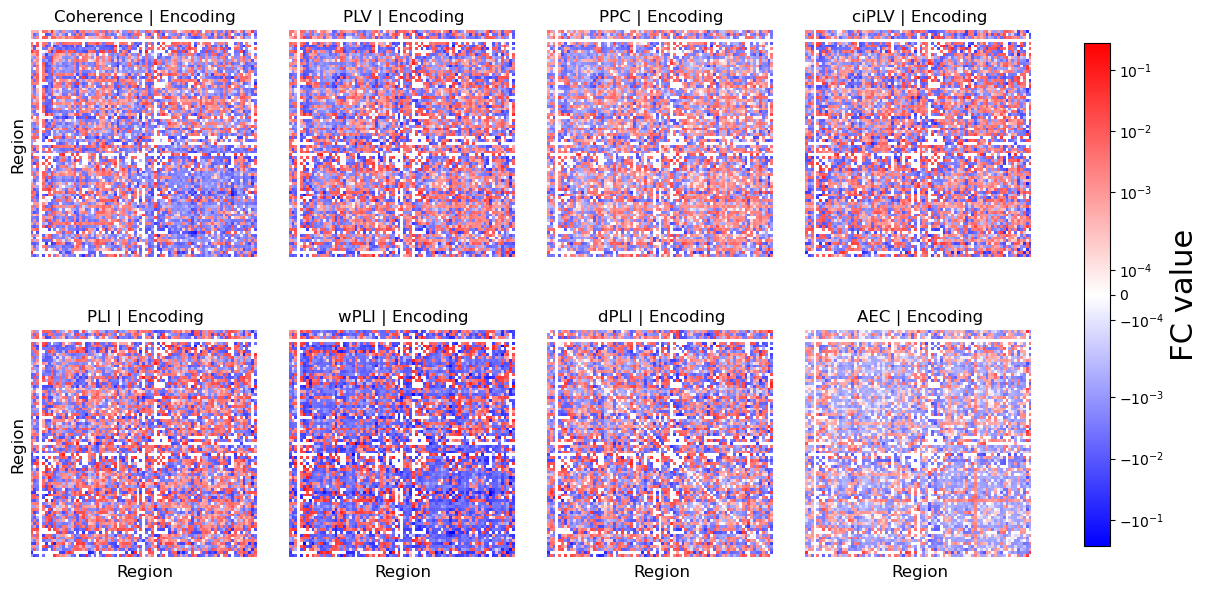

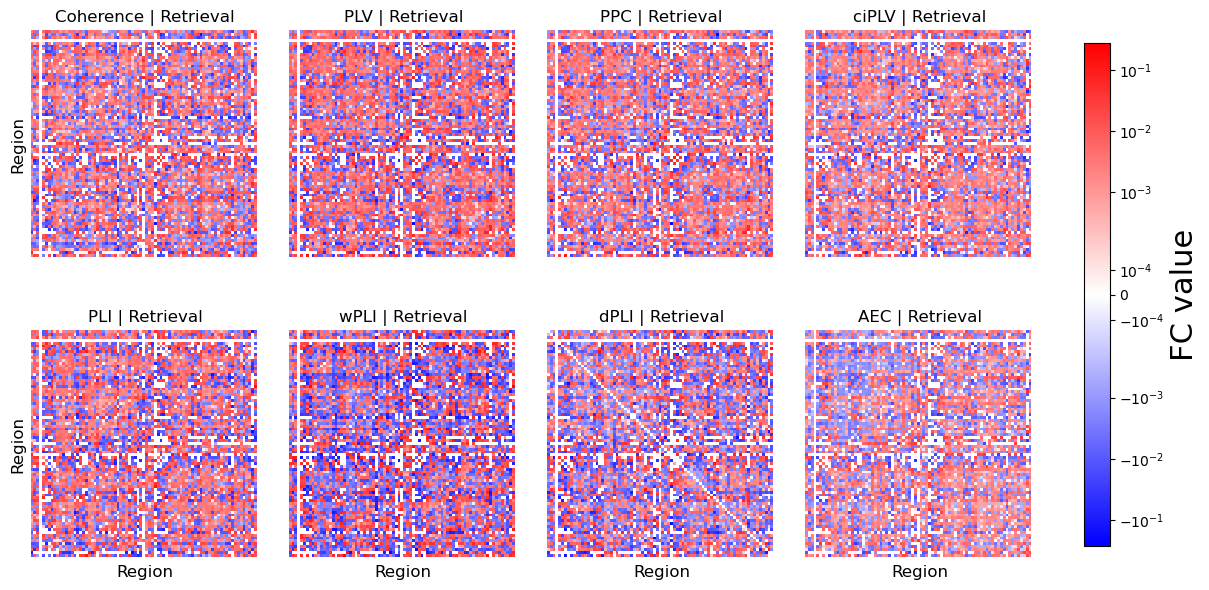

In [15]:
from matplotlib.colors import SymLogNorm

for beh, title, out_png in [("en", "Encoding", "encoding_allmats.png"),
                           ("rm", "Retrieval", "retrieval_allmats.png")]:

    avg_region = pd.read_pickle(f"avg_region_{beh}.pkl")

    valid = [avg_region[m] for m in metrics if (avg_region[m] is not None and m not in asymm)]
    vmax = np.nanmax(np.abs(np.stack(valid))) if len(valid) else 1.0
    vmin = -vmax

    linthresh = max(vmax * 1e-3, 1e-12)
    norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax, base=10)

    nrows, ncols = 2, 4
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 6), layout="constrained")
    axs = axs.ravel()

    cmap = plt.cm.bwr
    mappable = None

    for i, m in enumerate(metrics):
        ax = axs[i]
        mat = avg_region.get(m, None)

        if mat is None:
            ax.set_title(f"{m}: no data")
            ax.axis("off")
            continue

        hm = sns.heatmap(
            mat,
            ax=ax,
            cmap=cmap,
            norm=norm,
            square=True,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
        )
        ax.set_title(f"{correct_labels[m]} | {title}")
        ax.set_ylabel("Region" if i in (0, 4) else " ", fontsize=12)
        ax.set_xlabel("Region" if i in (4, 5, 6, 7) else " ", fontsize=12)

        if mappable is None:
            mappable = hm.collections[0]

    for j in range(len(metrics), nrows * ncols):
        axs[j].axis("off")

    cbar = fig.colorbar(mappable, ax=axs, location="right", shrink=0.85)
    cbar.set_label("FC value")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()


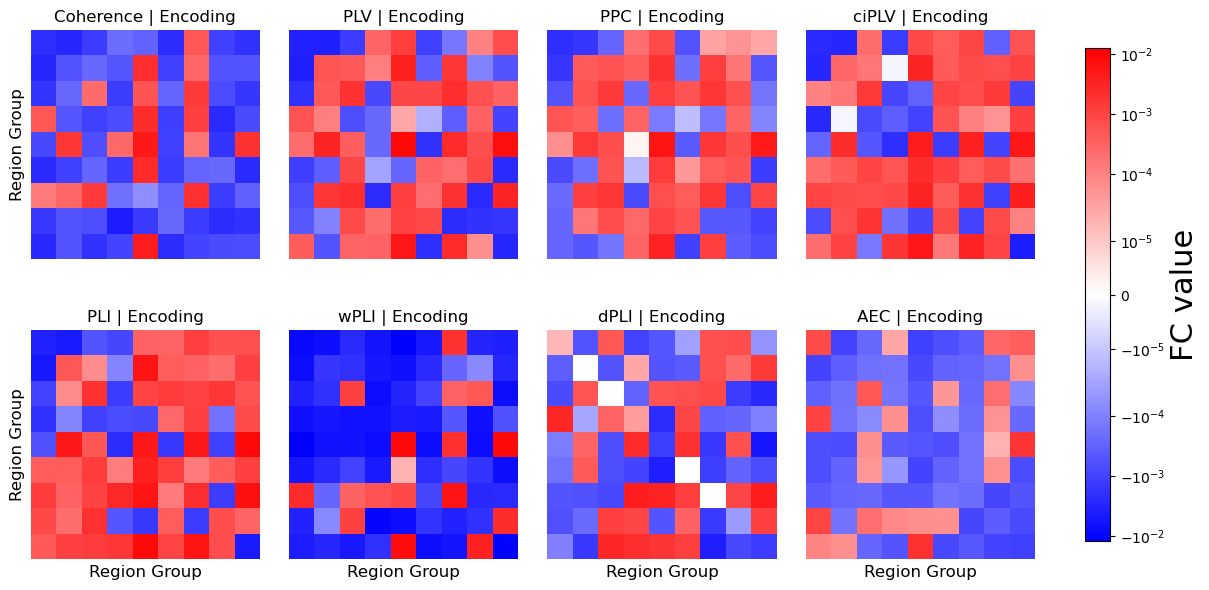

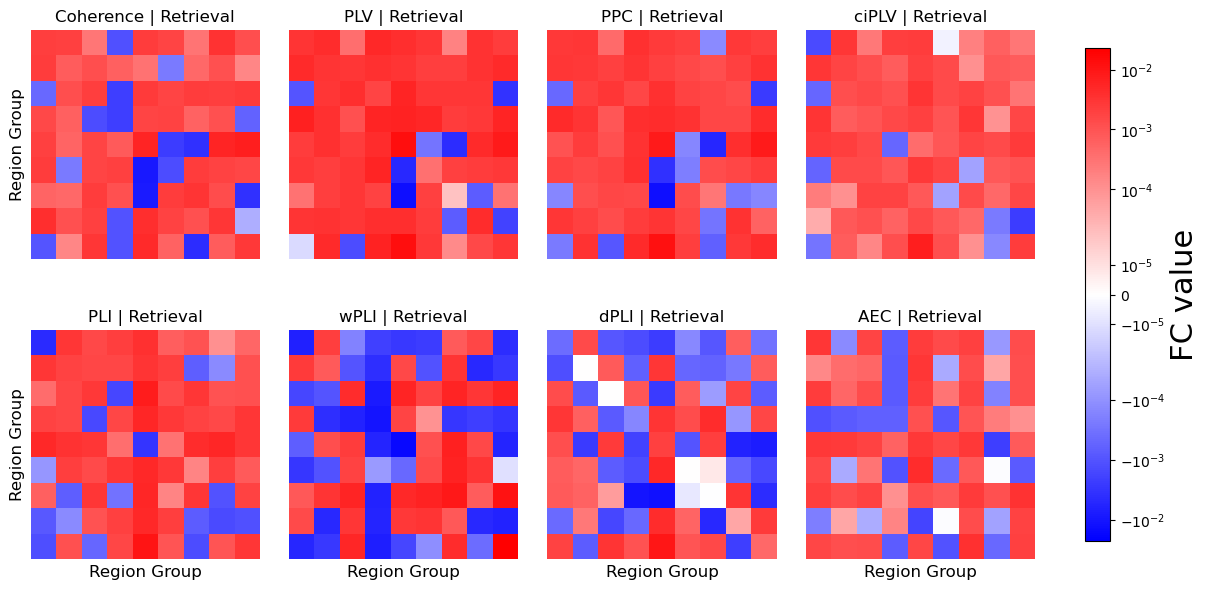

In [58]:
rg = pd.read_csv("constants/region_groups_standard.csv", dtype=str).rename(columns=str.strip) 
rg["region"] = rg["region"].str.strip().str.lower()
rg["group"]  = rg["group"].str.strip()

regions_df = pd.DataFrame({"reg_full": regionlabels})
regions_df["hemi"] = regions_df["reg_full"].str.split().str[0]
regions_df["region"] = regions_df["reg_full"].str.split(n=1).str[1].str.strip().str.lower()

regions_df = regions_df.merge(rg, on="region", how="left")
regions_df["group"] = regions_df["group"].fillna("unmapped")

region_to_group = dict(zip(regions_df["reg_full"], regions_df["group"]))

def collapse_to_groups(mat, regionlabels):
    assert mat.shape[0] == len(regionlabels)
    idx = np.array([region_to_group[r] for r in regionlabels], dtype=object)
    df = pd.DataFrame(mat, index=idx, columns=idx)
    return df.groupby(level=0).mean().T.groupby(level=0).mean().T


for beh, title, out_png in [("en", "Encoding", "encoding_allmats.png"),
                           ("rm", "Retrieval", "retrieval_allmats.png")]:

    avg_region = pd.read_pickle(f"avg_region_{beh}.pkl")

    valid = [collapse_to_groups(avg_region[m], regionlabels).to_numpy()
         for m in metrics if (avg_region[m] is not None and m not in asymm)]
    
    vmax = np.nanmax(np.abs(np.stack(valid))) if len(valid) else 1.0
    vmin = -vmax

    linthresh = max(vmax * 1e-3, 1e-12)
    norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax, base=10)

    nrows, ncols = 2, 4
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 6), layout="constrained")
    axs = axs.ravel()

    cmap = plt.cm.bwr
    mappable = None

    for i, m in enumerate(metrics):
        ax = axs[i]
        mat = avg_region.get(m, None)

        if mat is None:
            ax.set_title(f"{m}: no data")
            ax.axis("off")
            continue
            
        group_mat = collapse_to_groups(mat, regionlabels)
        hm = sns.heatmap(
            group_mat,
            ax=ax,
            cmap=cmap,
            norm=norm,
            square=True,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
        )
        ax.set_title(f"{correct_labels[m]} | {title}")
        ax.set_ylabel("Region Group" if i in (0, 4) else " ", fontsize=12)
        ax.set_xlabel("Region Group" if i in (4, 5, 6, 7) else " ", fontsize=12)

        if mappable is None:
            mappable = hm.collections[0]

    for j in range(len(metrics), nrows * ncols):
        axs[j].axis("off")

    cbar = fig.colorbar(mappable, ax=axs, location="right", shrink=0.85)
    cbar.set_label("FC value")
    plt.show()


## Measure x Measure Correlations

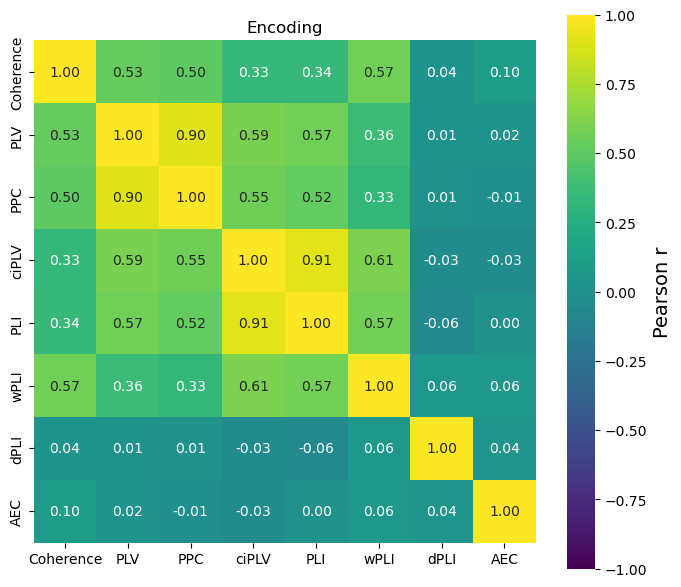

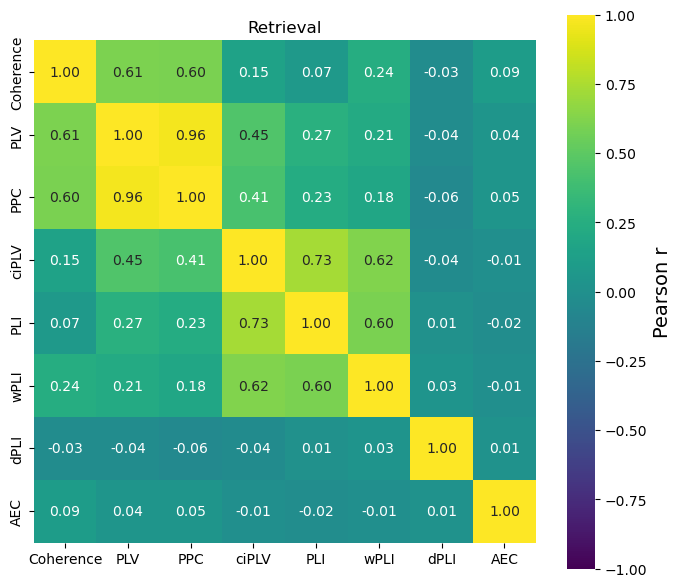

In [59]:
from scipy.stats import pearsonr

def uppertri_vec(mat, k=1):
    iu = np.triu_indices(mat.shape[0], k=k)
    return mat[iu]

def pairwise_corr_nan(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 3:
        return np.nan
    return pearsonr(x[mask], y[mask]).statistic

for beh, title, out_png in [("en", "Encoding", "encoding_measurecorrs.png"),
                           ("rm", "Retrieval", "retrieval_measurecorrs.png")]:

    avg_region = pd.read_pickle(f"avg_region_{beh}.pkl")

    vecs = {m: uppertri_vec(avg_region[m], k=1) for m in metrics if avg_region.get(m) is not None}

    C = pd.DataFrame(index=metrics, columns=metrics, dtype=float)
    for mi in metrics:
        for mj in metrics:
            C.loc[mi, mj] = pairwise_corr_nan(vecs[mi], vecs[mj]) if (mi in vecs and mj in vecs) else np.nan

    C_correct = C.rename(index=correct_labels, columns=correct_labels)  

    plt.figure(figsize=(7, 6))
    ax = sns.heatmap(C_correct, vmin=-1, vmax=1, center=0, cmap="viridis",
                 annot=True, fmt=".2f", square=True, cbar_kws={"label": "Pearson r"})
    ax.figure.axes[-1].yaxis.label.set_size(14)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()


## Mean FC Values per Measure

In [27]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection

def summarize_matrix(M, metric_name):
    M = np.asarray(M)
    if metric_name in asymm:
        mask = ~np.eye(M.shape[0], dtype=bool)   
        v = M[mask]
    else:
        iu = np.triu_indices(M.shape[0], 1)      
        v = M[iu]
    return np.nanmean(v)

def compute_meanfc_barplot(results, beh, title):
    by_sub = {m: {} for m in metrics}

    for r in results:
        if r is None:
            continue

        sub = r["sid"][0]
        reg_full = r["reg_full"]

        for m in metrics:
            el = np.asarray(r[m])

            if m in asymm:
                el = el.copy()
                np.fill_diagonal(el, np.nan)
            else:
                el = symmetrize_dense(el, diag_value=np.nan)

            reg_mat = electrode_to_region_mean(el, reg_full)
            by_sub[m].setdefault(sub, []).append(reg_mat)

    subj_mat = {m: {} for m in metrics}
    for m in metrics:
        for sub, mats in by_sub[m].items():
            subj_mat[m][sub] = np.nanmean(np.stack(mats, axis=0), axis=0)

    pd.to_pickle(subj_mat, f"subj_mat_{beh}.pkl")  

    subs_common = sorted(set.intersection(*[set(subj_mat[m].keys()) for m in metrics]))
    df = pd.DataFrame(
        {m: [summarize_matrix(subj_mat[m][sub], m) for sub in subs_common] for m in metrics},
        index=subs_common,
        dtype=float,
    )

    pairs = list(itertools.combinations(metrics, 2))
    pvals = np.full(len(pairs), np.nan, dtype=float)

    for i, (a, b) in enumerate(pairs):
        x = df[a].to_numpy()
        y = df[b].to_numpy()
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() >= 3:
            pvals[i] = ttest_rel(x[mask], y[mask]).pvalue  

    finite = np.isfinite(pvals)
    rej = np.zeros_like(pvals, dtype=bool)
    qvals = np.full_like(pvals, np.nan)
    if finite.any():
        rej_f, q_f = fdrcorrection(pvals[finite], alpha=0.05) 
        rej[finite] = rej_f
        qvals[finite] = q_f

    sig_pairs = [(pairs[i][0], pairs[i][1], qvals[i]) for i in range(len(pairs)) if rej[i]]

    means = df.mean(axis=0, skipna=True)
    sems  = df.sem(axis=0, skipna=True)

    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(len(metrics))

    ax.bar(
        x,
        means[metrics].values,
        yerr=sems[metrics].values,
        capsize=4,
        alpha=0.9,
        color="tab:blue",
    )

    ax.set_xticks(x)
    ax.set_xticklabels([correct_labels[m] for m in metrics], rotation=45, ha="right")
    ax.set_ylabel("Mean connectivity", fontsize=12)
    ax.set_ylim(-0.003, 0.003)

    plt.tight_layout()
    plt.title(title)
    plt.savefig(f"{beh}_allmeanconnectivity.png", dpi=300, bbox_inches="tight")
    plt.show()

    return subj_mat, df, sig_pairs

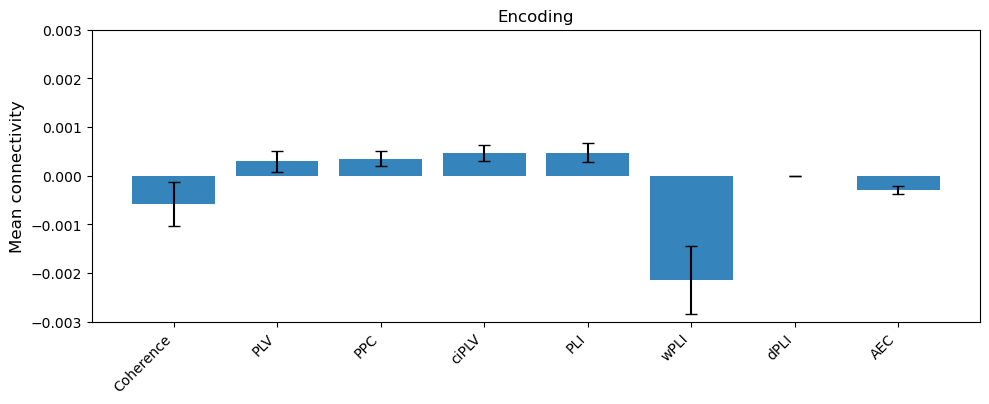

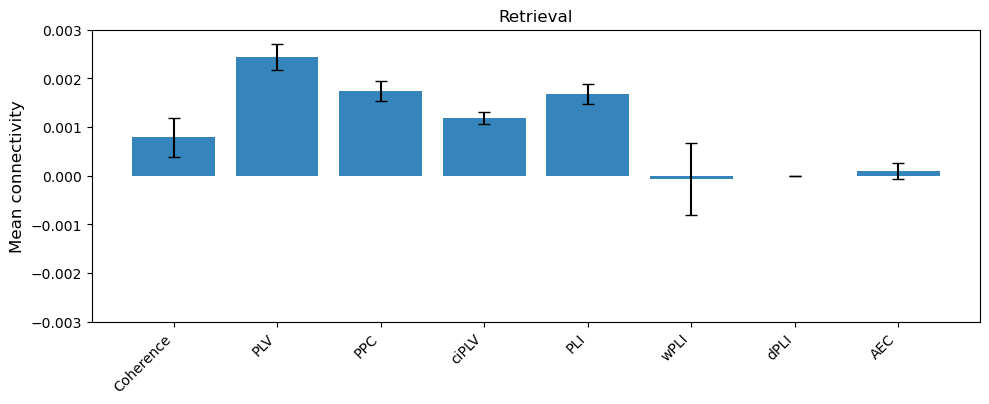

In [28]:
results_by_beh = {"en": results_en, "rm": results_rm}
titles_by_beh  = {"en": "Encoding", "rm": "Retrieval"}

outputs = {}
for beh in ["en", "rm"]:
    outputs[beh] = compute_meanfc_barplot(results_by_beh[beh], beh=beh, title=titles_by_beh[beh])

## Subsample Similarity Curve

In [29]:
def vec_for_metric_map(A, m):
    A = np.asarray(A)
    if m in asymm:
        mask = ~np.eye(A.shape[0], dtype=bool)  
        return A[mask]
    else:
        iu = np.triu_indices(A.shape[0], 1)      
        return A[iu]

def corr_nan(a, b, min_n=10):
    a = np.asarray(a)
    b = np.asarray(b)
    mask = np.isfinite(a) & np.isfinite(b)
    if mask.sum() < min_n:
        return np.nan
    return pearsonr(a[mask], b[mask]).statistic

In [30]:
def run_similarity_curve(subj_mat, beh, title, seed=0, n_resamples=1000, confidence_level=0.95):
    valid_subjects_strict = sorted(set.intersection(*[set(subj_mat[m].keys()) for m in metrics]))
    print(f"{title}: Valid subjects with all metrics:", len(valid_subjects_strict))

    subject_pool = np.array(valid_subjects_strict)
    S = len(subject_pool)
    if S < 5:
        raise ValueError(f"{title}: need at least 5 subjects, found {S}")

    maxN = min(300, S)
    Ns = np.unique(np.round(np.logspace(np.log10(5), np.log10(maxN), 20)).astype(int))
    Ns = Ns[Ns >= 5]

    rng = np.random.default_rng(seed)
    alpha = 1.0 - confidence_level

    X = {m: np.stack([subj_mat[m][sub] for sub in subject_pool], axis=0) for m in metrics}

    ref_vec = {}
    for m in metrics:
        A_full = np.nanmean(X[m], axis=0)
        ref_vec[m] = vec_for_metric_map(A_full, m)

    rows = []
    for m in metrics:
        Xm = X[m]          
        ref = ref_vec[m]   

        for N in Ns:
            boot_idx = rng.integers(0, S, size=(n_resamples, N))

            vals = np.empty(n_resamples, float)
            for b in range(n_resamples):
                A_hat = np.nanmean(Xm[boot_idx[b]], axis=0)  
                vals[b] = corr_nan(vec_for_metric_map(A_hat, m), ref)

            rows.append({
                "behavior": beh,
                "metric": m,
                "N": int(N),
                "mean": float(np.nanmean(vals)),
                "ci_low": float(np.nanquantile(vals, alpha / 2)),
                "ci_high": float(np.nanquantile(vals, 1 - alpha / 2)),
            })

    df_plot = pd.DataFrame(rows)
    df_plot.to_pickle(f"{beh}_similarity_curve_df.pkl")  xs
    fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")

    for m in metrics:
        d = df_plot.query("metric == @m").sort_values("N")
        ax.plot(d["N"], d["mean"], label=correct_labels.get(m, m))
        ax.fill_between(d["N"], d["ci_low"], d["ci_high"], alpha=0.1)

    #ax.set_xscale("log")
    ax.set_xlabel("Number of Subjects")
    ax.set_ylabel("Pearson r")
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.legend(ncols=2, frameon=False, fontsize=14)
    sns.despine()
    plt.savefig(f"{beh}_similarity_curve.png", dpi=300, bbox_inches="tight")
    plt.title(title)
    plt.show()

    return df_plot

Encoding: Valid subjects with all metrics: 383


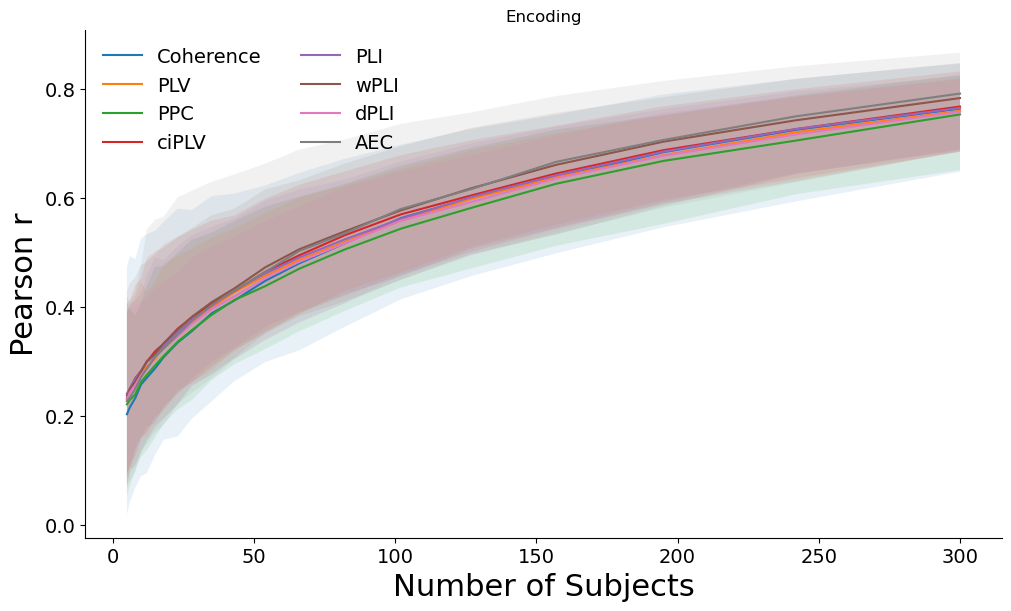

In [31]:
for beh, title, seed in [("en", "Encoding", 0)]:
    subj_mat = pd.read_pickle(f"subj_mat_{beh}.pkl")  
    run_similarity_curve(subj_mat, beh=beh, title=title, seed=seed)

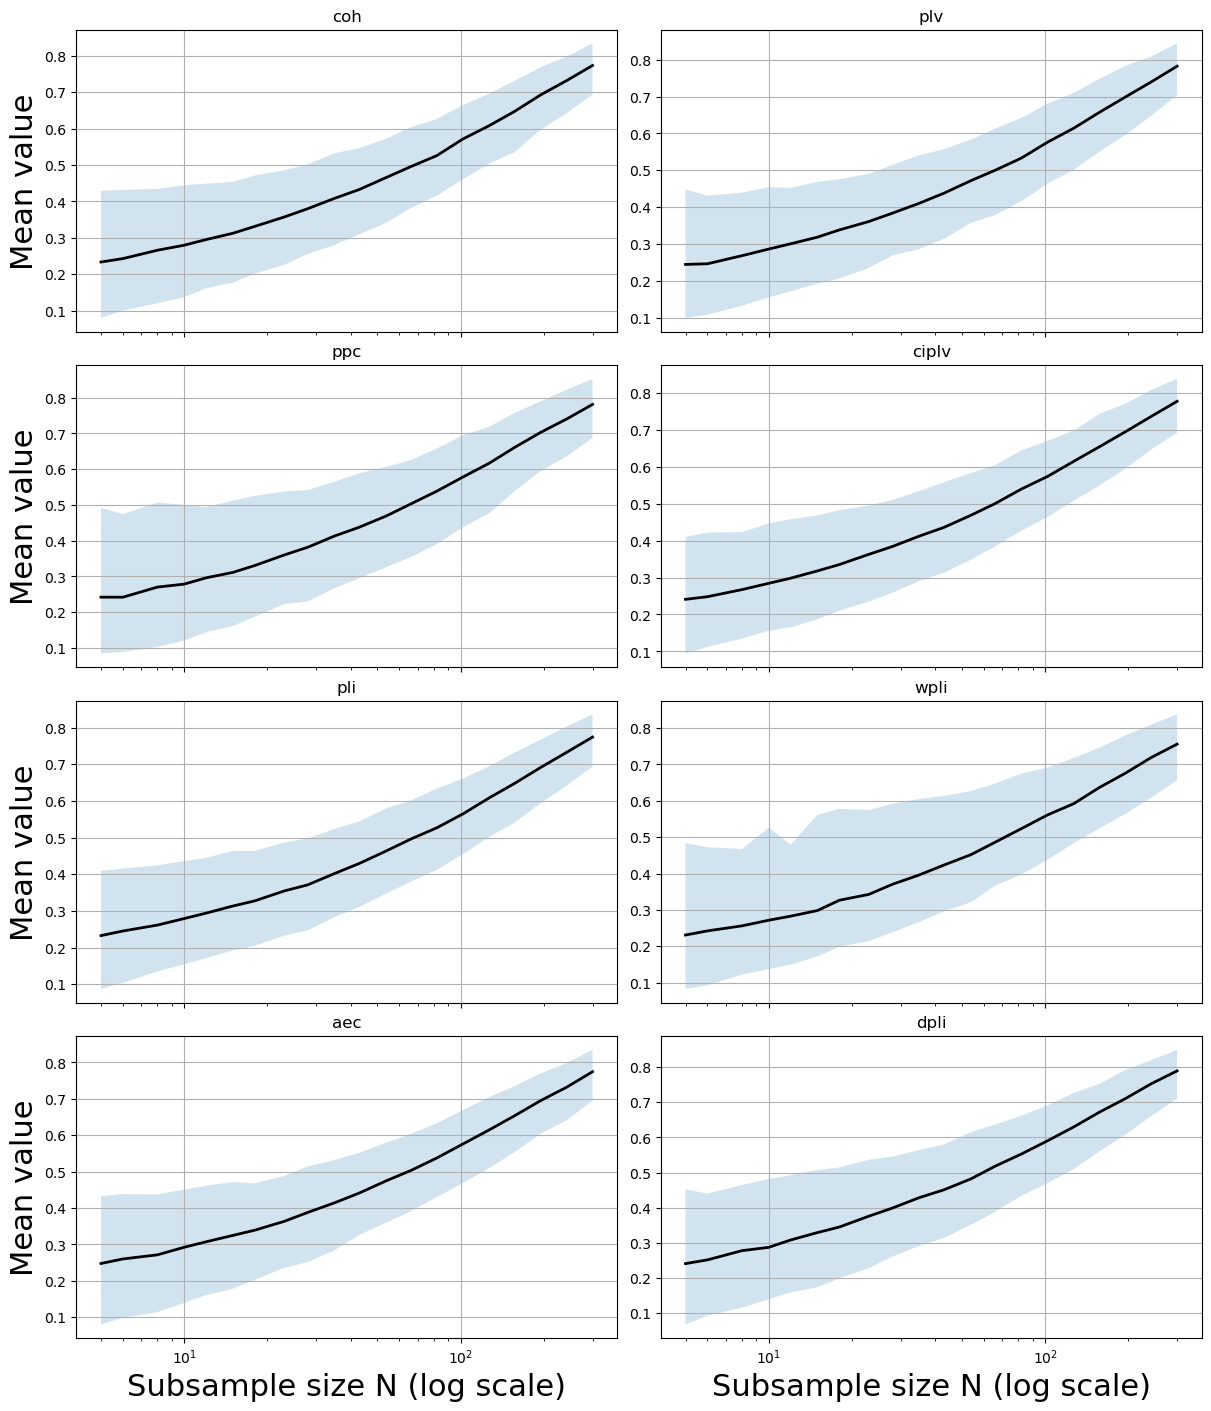

In [97]:
#nrows, ncols = 4, 2

#for beh, title, out_png in [
#    ("en", "Encoding", "encoding_similarity_curve_grid.png"),
#    ("rm", "Retrieval", "retrieval_similarity_curve_grid.png"),
#]:
#    dfb = df_plot.query("behavior == @beh") 

#    fig, axs = plt.subplots(
#        nrows, ncols,
#        figsize=(12, 14),
#        sharex=True,
#        layout="constrained",
#    )
#    axs = axs.ravel()

#    for ax, m in zip(axs, metrics):
#        d = dfb.query("metric == @m").sort_values("N")
#        ax.plot(d["N"], d["mean"], color="k", lw=2)
#        ax.fill_between(d["N"], d["ci_low"], d["ci_high"], alpha=0.2)
#        ax.set_title(correct_labels.get(m, m))
#        ax.set_xscale("log")
#        ax.grid(True)

#    for ax in axs[-ncols:]:
#        ax.set_xlabel("Subsample size N (log scale)")
#    for ax in axs[::ncols]:
#        ax.set_ylabel("Pearson r")

#    fig.suptitle(title)
#    plt.savefig(out_png, dpi=300, bbox_inches="tight")
#    plt.show()


## Mockup Figures for Proposal

[0.000999 0.000999 0.000999 0.000999 0.000999 0.000999 0.000999 0.000999]


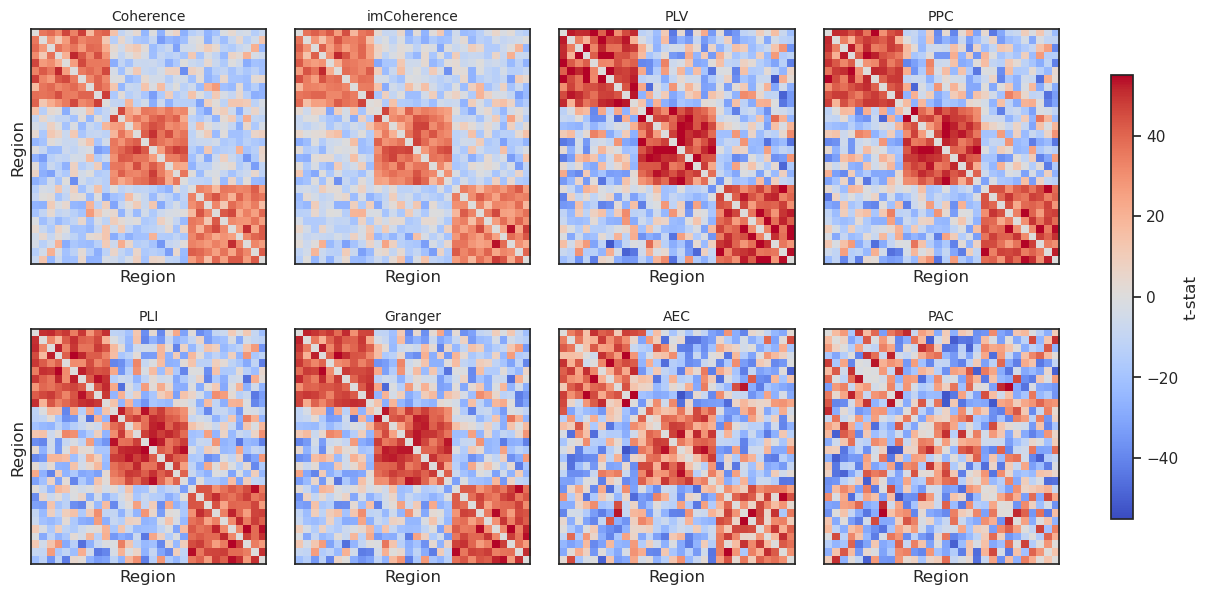

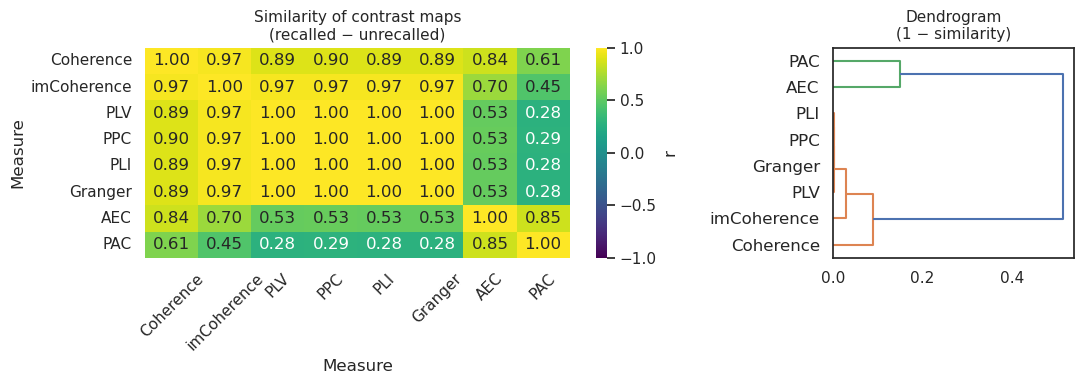

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster import hierarchy as sch
from scipy.spatial import distance as sdist
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(22)

n_subjects = 380
n_nodes = 30
n_measures = 8
measure_names = ['Coherence', 'imCoherence', 'PLV', 'PPC', 'PLI', 'Granger', 'AEC', 'PAC']

FC = np.zeros((n_measures, n_subjects, 2, n_nodes, n_nodes))

triu_idx = np.triu_indices(n_nodes, k=1)

n_comm = 3
sizes = [10, 10, 10]
labels = np.concatenate([np.full(sizes[k], k) for k in range(n_comm)])

base_comm = np.array([[0.10, 0.03, 0.01],
                      [0.03, 0.08, 0.02],
                      [0.01, 0.02, 0.06]])

def symm_zero_diag(M):
    M = (M + M.T) / 2
    np.fill_diagonal(M, 0)
    return M

base_template = np.zeros((n_nodes, n_nodes))
for i in range(n_nodes):
    for j in range(n_nodes):
        if i == j:
            continue
        base_template[i, j] = base_comm[labels[i], labels[j]]
base_template = symm_zero_diag(base_template)

H = np.random.randn(n_nodes, n_nodes)
H = symm_zero_diag(H)
H = H / (np.std(H[triu_idx]) + 1e-12)

Q = np.random.randn(n_nodes, n_nodes)
Q = symm_zero_diag(Q)
Q = Q / (np.std(Q[triu_idx]) + 1e-12)

comm_template = np.zeros((n_nodes, n_nodes))
for i in range(n_nodes):
    for j in range(n_nodes):
        if i == j:
            continue
        comm_template[i, j] = (labels[i] == labels[j]).astype(float) - 0.2 * (labels[i] != labels[j]).astype(float)
comm_template = symm_zero_diag(comm_template)
comm_template = comm_template / (np.std(comm_template[triu_idx]) + 1e-12)

phase_latent = 0.8 * comm_template + 0.5 * H
phase_latent = symm_zero_diag(phase_latent)
phase_latent = phase_latent / (np.std(phase_latent[triu_idx]) + 1e-12)

amp_latent = 0.6 * comm_template + 0.7 * Q
amp_latent = symm_zero_diag(amp_latent)
amp_latent = amp_latent / (np.std(amp_latent[triu_idx]) + 1e-12)

pac_latent = 0.2 * comm_template + 0.9 * Q + 0.2 * H
pac_latent = symm_zero_diag(pac_latent)
pac_latent = pac_latent / (np.std(pac_latent[triu_idx]) + 1e-12)

phase_idx = [2, 3, 4, 5]
amp_idx = [6]
pac_idx = [7]
coh_idx = [0]
imcoh_idx = [1]

def logistic(x):
    return 1 / (1 + np.exp(-x))

for m in range(n_measures):
    for s in range(n_subjects):
        subject_shift = 0.15 * np.random.randn()
        subject_scale = np.exp(0.15 * np.random.randn())

        base_noise = np.random.normal(0, 0.03, size=(n_nodes, n_nodes))
        base_noise = symm_zero_diag(base_noise)

        base_fc = subject_scale * (base_template + 0.06 * comm_template + 0.02 * H) + subject_shift + base_noise
        base_fc = symm_zero_diag(base_fc)

        a0 = 0.05 * np.random.randn()
        a1 = a0 + 0.10 + 0.03 * np.random.randn()

        if m in phase_idx:
            latent = phase_latent
            amp = 0.25 + 0.08 * np.random.randn()
            leak = 0.05 + 0.02 * np.random.randn()
        elif m in amp_idx:
            latent = amp_latent
            amp = 0.18 + 0.06 * np.random.randn()
            leak = 0.03 + 0.01 * np.random.randn()
        elif m in pac_idx:
            latent = pac_latent
            amp = 0.14 + 0.06 * np.random.randn()
            leak = 0.02 + 0.01 * np.random.randn()
        elif m in coh_idx:
            latent = 0.45 * phase_latent + 0.35 * amp_latent
            amp = 0.22 + 0.06 * np.random.randn()
            leak = 0.10 + 0.03 * np.random.randn()
        else:
            latent = 0.55 * phase_latent + 0.15 * amp_latent
            amp = 0.16 + 0.05 * np.random.randn()
            leak = 0.06 + 0.02 * np.random.randn()

        shared = symm_zero_diag(np.ones((n_nodes, n_nodes)))
        leak_term = leak * shared

        eps0 = np.random.normal(0, 0.05, size=(n_nodes, n_nodes))
        eps0 = symm_zero_diag(eps0)
        eps1 = np.random.normal(0, 0.05, size=(n_nodes, n_nodes))
        eps1 = symm_zero_diag(eps1)

        raw0 = base_fc + a0 * latent + leak_term + eps0
        raw1 = base_fc + a1 * latent + leak_term + eps1

        if m == 0:
            FC[m, s, 0] = logistic(raw0)
            FC[m, s, 1] = logistic(raw1)
        elif m == 1:
            FC[m, s, 0] = np.tanh(raw0 / 1.2)
            FC[m, s, 1] = np.tanh(raw1 / 1.2)
        elif m in phase_idx:
            FC[m, s, 0] = logistic(raw0 / 1.1)
            FC[m, s, 1] = logistic(raw1 / 1.1)
        elif m in amp_idx:
            FC[m, s, 0] = np.tanh(raw0 / 1.3)
            FC[m, s, 1] = np.tanh(raw1 / 1.3)
        elif m in pac_idx:
            FC[m, s, 0] = np.tanh(raw0 / 1.1)
            FC[m, s, 1] = np.tanh(raw1 / 1.1)

        np.fill_diagonal(FC[m, s, 0], 0)
        np.fill_diagonal(FC[m, s, 1], 0)

D = FC[:, :, 1] - FC[:, :, 0]

t_maps = np.zeros((n_measures, n_nodes, n_nodes))
p_maps = np.zeros((n_measures, n_nodes, n_nodes))

for m in range(n_measures):
    data = D[m, :, triu_idx[0], triu_idx[1]]
    t_vals, p_vals = stats.ttest_1samp(data, popmean=0.0, axis=1)

    t_mat = np.zeros((n_nodes, n_nodes))
    p_mat = np.ones((n_nodes, n_nodes))
    t_mat[triu_idx] = t_vals
    p_mat[triu_idx] = p_vals

    t_mat = t_mat + t_mat.T
    p_mat = p_mat + p_mat.T - np.eye(n_nodes)
    t_maps[m] = t_mat
    p_maps[m] = p_mat

similarity = np.zeros((n_measures, n_measures))
for i in range(n_measures):
    for j in range(n_measures):
        v1 = t_maps[i][triu_idx]
        v2 = t_maps[j][triu_idx]
        similarity[i, j] = np.corrcoef(v1, v2)[0, 1]

dissimilarity = 1 - similarity
np.fill_diagonal(dissimilarity, 0)
condensed = sdist.squareform(dissimilarity, checks=False)
linkage = sch.linkage(condensed, method='average')

n_perm = 1000
global_effects = np.zeros((n_measures, n_subjects))
obs_mean = np.zeros(n_measures)
p_perm = np.zeros(n_measures)

for m in range(n_measures):
    data = D[m, :, triu_idx[0], triu_idx[1]]
    subj_vals = data.mean(axis=0)
    global_effects[m] = subj_vals
    obs_mean[m] = subj_vals.mean()

    null_means = np.zeros(n_perm)
    for p in range(n_perm):
        signs = np.random.choice([-1, 1], size=n_subjects)
        null_means[p] = (signs * subj_vals).mean()

    p_perm[m] = (np.sum(np.abs(null_means) >= np.abs(obs_mean[m])) + 1) / (n_perm + 1)
print(p_perm)
sns.set(style="white", context="notebook")

fig1, axes = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)
axes = axes.ravel()
vmax = np.percentile(np.abs(t_maps), 99)

for m, ax in enumerate(axes):
    im = ax.imshow(t_maps[m], vmin=-vmax, vmax=vmax, cmap='coolwarm')
    ax.set_title(measure_names[m], fontsize=10)
    if m in (0, 4):
        ax.set_ylabel("Region")
    else:
        ax.set_ylabel(" ")
    ax.set_xlabel("Region")
    ax.set_xticks([])
    ax.set_yticks([])

cbar = fig1.colorbar(im, ax=axes.tolist(), shrink=0.75)
cbar.set_label('t-stat')
plt.show()

fig2, ax2 = plt.subplots(1, 2, figsize=(11, 4), gridspec_kw={'width_ratios': [2.2, 1]})

sns.heatmap(similarity, ax=ax2[0], annot=True, fmt=".2f",
            xticklabels=measure_names, yticklabels=measure_names,
            cmap='viridis', vmin=-1, vmax=1, cbar_kws={'label': 'r'})
ax2[0].set_title("Similarity of contrast maps\n(recalled − unrecalled)", fontsize=11)
ax2[0].tick_params(axis='x', rotation=45) 
ax2[0].set_xlabel("Measure")
ax2[0].set_ylabel("Measure")

sch.dendrogram(linkage, labels=measure_names, ax=ax2[1], orientation='right')
ax2[1].set_title("Dendrogram\n(1 − similarity)", fontsize=11)

plt.tight_layout()
plt.show()



NameError: name 'iou_mat' is not defined

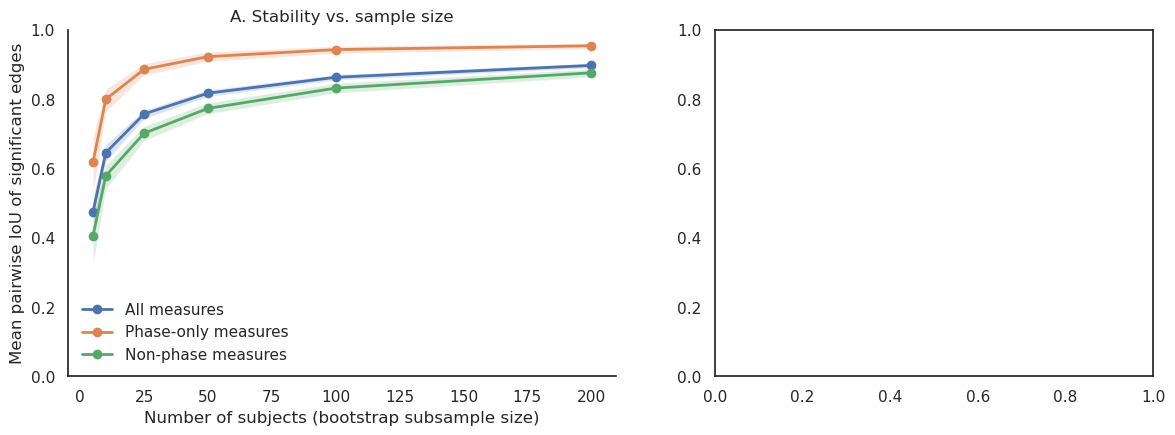

In [3]:
from itertools import combinations

def iou_binary(mask_a, mask_b):
    a = np.asarray(mask_a, dtype=bool)
    b = np.asarray(mask_b, dtype=bool)
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / union if union > 0 else np.nan

def significant_edge_mask(D_m_subj, alpha=0.05):
    t, p = stats.ttest_1samp(D_m_subj, popmean=0.0, axis=0, nan_policy='omit')
    return (p < alpha)

def mean_pairwise_iou(masks, idx_list=None):
    if idx_list is None:
        idx_list = list(range(len(masks)))
    pairs = list(combinations(idx_list, 2))
    vals = []
    for i, j in pairs:
        vals.append(iou_binary(masks[i], masks[j]))
    return np.nanmean(vals) if len(vals) else np.nan

phase_idx = [2, 3, 4, 5]        
nonphase_idx = [0, 1, 6, 7]     

subsample_sizes = [5, 10, 25, 50, 100, 200]
subsample_sizes = [n for n in subsample_sizes if n <= n_subjects]  
n_boot = 500          
alpha = 0.05         
rep_size = 25      

D_edges = np.zeros((n_measures, n_subjects, len(triu_idx[0])))
for m in range(n_measures):
    D_edges[m] = D[m][:, triu_idx[0], triu_idx[1]] 
    
results = {n: {"all": [], "phase": [], "nonphase": []} for n in subsample_sizes}

rng = np.random.default_rng(42)

for n in subsample_sizes:
    for b in range(n_boot):
        samp = rng.integers(0, n_subjects, size=n)

        masks = []
        for m in range(n_measures):
            mask_m = significant_edge_mask(D_edges[m][samp, :], alpha=alpha)
            masks.append(mask_m)

        results[n]["all"].append(mean_pairwise_iou(masks))
        results[n]["phase"].append(mean_pairwise_iou(masks, idx_list=phase_idx))
        results[n]["nonphase"].append(mean_pairwise_iou(masks, idx_list=nonphase_idx))

def boot_mean_ci(x, ci=95):
    x = np.asarray(x)
    mu = np.nanmean(x)
    lo = np.nanpercentile(x, (100-ci)/2)
    hi = np.nanpercentile(x, 100-(100-ci)/2)
    return mu, lo, hi

summ = []
for n in subsample_sizes:
    mu_all, lo_all, hi_all = boot_mean_ci(results[n]["all"])
    mu_ph,  lo_ph,  hi_ph  = boot_mean_ci(results[n]["phase"])
    mu_np,  lo_np,  hi_np  = boot_mean_ci(results[n]["nonphase"])
    summ.append([n, mu_all, lo_all, hi_all, mu_ph, lo_ph, hi_ph, mu_np, lo_np, hi_np])

summ = pd.DataFrame(
    summ,
    columns=["n", "all_mu", "all_lo", "all_hi",
             "phase_mu", "phase_lo", "phase_hi",
             "nonphase_mu", "nonphase_lo", "nonphase_hi"]
)

fig, axes = plt.subplots(
    1, 2, figsize=(14, 4.5),
    gridspec_kw={'width_ratios': [1.25, 1]}
)

ax = axes[0]

def plot_band(ax, x, mu, lo, hi, label):
    ax.plot(x, mu, marker='o', linewidth=2, label=label)
    ax.fill_between(x, lo, hi, alpha=0.2)

x = summ["n"].values
plot_band(ax, x, summ["all_mu"],      summ["all_lo"],      summ["all_hi"],      "All measures")
plot_band(ax, x, summ["phase_mu"],    summ["phase_lo"],    summ["phase_hi"],    "Phase-only measures")
plot_band(ax, x, summ["nonphase_mu"], summ["nonphase_lo"], summ["nonphase_hi"], "Non-phase measures")

ax.set_xlabel("Number of subjects (bootstrap subsample size)")
ax.set_ylabel("Mean pairwise IoU of significant edges")
ax.set_title("A. Stability vs. sample size")
ax.set_ylim(0, 1)
ax.legend(frameon=False)
sns.despine(ax=ax)

ax = axes[1]
sns.heatmap(
    iou_mat, ax=ax, vmin=0, vmax=1, cmap="viridis",
    xticklabels=measure_names, yticklabels=measure_names,
    cbar_kws={"label": "IoU"}
)
ax.set_title(f"B. IoU agreement (n=25 subjects)")
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Measure")
ax.set_ylabel("Measure")

plt.tight_layout()
plt.show()
